# Import statements

In [1]:
import pandas as pd
import numpy as np
from music21 import *
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from music21 import environment
# Set the path to MuseScore
env = environment.Environment()
env['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
env['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'

In [3]:
test = "..\\Music Database\\GTTM Database\\Alexander Porfir’evich Borodin\\Quartet for 2 Violins, Viola and Violoncello D major 3 Nocturne.xml"

# Functions

In [4]:
# Find all composers with more than 3 songs in the database
def get_directories_with_min_files(root_dir, min_file_count=3):
    qualifying_directories = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count the number of files in the current directory
        file_count = len([name for name in filenames if os.path.isfile(os.path.join(dirpath, name))])

        # Check if the current directory has at least min_file_count files
        if file_count > min_file_count:
            qualifying_directories.append(os.path.basename(dirpath))

    return qualifying_directories

### Music Information Retrieval

In [5]:
def get_notes(score):
    element_array = []
    for part in score.parts:
        for element in part.flatten():
            element_array.append(element)
    return element_array

def get_notes_with_details(score):
    note_details = []
    for part in score.parts:
        for element in part.flatten().notesAndRests:  # This now includes both notes, chords, and rests
            if isinstance(element, note.Note):
                note_details.append((element, element.offset, element.measureNumber))
            elif isinstance(element, chord.Chord):
                # Loop through each note in the chord, appending with details
                for n in element.notes:
                    note_details.append((n, element.offset, element.measureNumber))
            elif isinstance(element, note.Rest):
                # Include details for rests
                note_details.append((element, element.offset, element.measureNumber))
    return note_details

### Implication-Realization Ruleset

In [6]:
def calculate_ir_symbol(interval1, interval2, threshold=5):
    direction = interval1 * interval2
    abs_difference = abs(interval2-interval1)
    # Process
    if direction > 0 and (abs(interval2-interval1))<threshold:
        return 'P'  
    # IR2: D (Duplication)
    elif interval1 == interval2 == 0:
        return 'D' 
    # IR3: IP (Intervallic Process)
    elif ((interval1 * interval2)<0) and (-threshold <= (abs(interval2) - abs(interval1)) <= threshold) and (abs(interval2) != abs(interval1)):
        return 'IP' 
    # IR4: ID (Intervallic Duplication)
    elif ((interval1 * interval2) < 0) and (abs(interval2) == abs(interval1)):
        return 'ID'   
    # IR5: VP (Vector Process)
    elif (interval1 * interval2 > 0) and (abs(interval2-interval1) >= threshold) and (abs(interval1) <= threshold):
        return 'VP'
    # IR6: R (Reveral)
    elif (interval1 * interval2 < 0) and (abs(abs(interval2)-abs(interval1)) >= threshold) and (abs(interval1) >= threshold):
        return 'R'
    # IR7: IR (Intervallic Reveral)
    elif (interval1 * interval2 > 0) and (abs(abs(interval2)-abs(interval1)) >= threshold) and (abs(interval1) >= threshold):
        return 'IR' 
    # IR8: VR (Vector Reveral)
    elif (interval1 * interval2 < 0) and (abs(interval2 - interval1) >= threshold) and (abs(interval1) <= threshold):
        return 'VR'
    elif interval2 == 0 and not (interval1 < -5 or interval1 > 5):
        return 'IP'
    elif interval2 == 0 and (interval1 < -5 or interval1 > 5):
        return 'R'
    elif interval1 == 0 and not (interval2 < -5 or interval2 > 5):
        return 'P'
    elif interval1 == 0 and (interval2 < -5 or interval2 > 5):
        return 'VR'

In [7]:
def get_root_interval(chord1, chord2):
    root1 = chord1.root()
    root2 = chord2.root()
    intv = interval.notesToChromatic(root1, root2)
    return intv.semitones

def get_average_interval(chord1, chord2):
    intervals = []
    for n1 in chord1.notes:
        for n2 in chord2.notes:
            intv = interval.notesToChromatic(n1, n2)
            intervals.append(intv.semitones)
    if intervals:
        return sum(intervals) / len(intervals)
    return 0

In [8]:
def assign_ir_symbols(elements):
    symbols = []
    current_group = [] 
    group_pitches = []
    
    color_map = {
        'P': 'blue',         
        'D': 'green',       
        'IP': 'red',        
        'ID': 'orange',      
        'VP': 'purple',      
        'R': 'cyan',         
        'IR': 'magenta',     
        'VR': 'yellow',     
        'M': 'pink',   
        'd': 'lime',    
    }

    def evaluate_current_group():
        if len(current_group) == 3:
            interval1 = group_pitches[1] - group_pitches[0]
            interval2 = group_pitches[2] - group_pitches[1]
            symbol = calculate_ir_symbol(interval1, interval2)
            color = color_map.get(symbol, 'black')  # Default to black if symbol is not predefined
            symbols.extend((note, symbol, color) for note in current_group)
        elif len(current_group) == 2:
            symbols.extend((note, 'd', color_map['d']) for note in current_group)
        elif len(current_group) == 1:
            symbols.extend((note, 'M', color_map['M']) for note in current_group)
        else:
            symbols.append('Error: Invalid note object')
        current_group.clear()
        group_pitches.clear()

    for element in elements:
        if isinstance(element, note.Note):
            current_group.append(element)
            group_pitches.append(element.pitch.ps)
            if len(current_group) == 3:
                evaluate_current_group()
        elif isinstance(element, chord.Chord):
            current_group.append(element)
            group_pitches.append(element.root().ps)
            if len(current_group) == 3:
                evaluate_current_group()
        elif isinstance(element, note.Rest):
            continue
            # # Remove continue for visualization
            # rest_tuple = (element, 'rest', 'black') 
            # evaluate_current_group()
            # symbols.append(rest_tuple)
        else:
            if current_group:
                evaluate_current_group()

    # Handle any remaining notes
    if current_group:
        evaluate_current_group()

    return symbols

In [9]:
def visualize_notes_with_symbols(notes_with_symbols):
    s = stream.Score()
    part = stream.Part()
    for note, symbol, color in notes_with_symbols:
        print(note, symbol, color)
        note.style.color = color
        note.lyric = symbol
        part.append(note)
    s.append(part)
    s.show()

# Usage

In [10]:
#  Identify unique states
states = ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']

# Create a mapping of states to indices for easier matrix manipulation
state_index = {state: i for i, state in enumerate(states)}
labels = enumerate(states)

# print("States:", states)
# print("Transition Matrix:\n", transition_matrix)

In [11]:
state_index

{'P': 0,
 'D': 1,
 'IP': 2,
 'ID': 3,
 'VP': 4,
 'R': 5,
 'IR': 6,
 'VR': 7,
 'M': 8,
 'd': 9}

In [12]:
# Store composers in a dictionary
root_directory = '../Music Database/GTTM Database' 
directories = get_directories_with_min_files(root_directory, 10)

In [13]:
directories.remove("Louis A. Saint-Jacome")
directories

['Franz Peter Schubert',
 'Frédéric Françoiss Chopin',
 'Ludwig van Beethoven',
 'Pyotr Il’yich Tchaikovsky',
 'Wolfgang Amadeus Mozart']

In [14]:
testscore = converter.parse(test)
notes = get_notes(testscore)
test_ir = assign_ir_symbols(notes)
type(test_ir)

list

<music21.note.Note G> M pink
<music21.note.Note F#> ID orange
<music21.note.Note E> ID orange
<music21.note.Note F#> ID orange
<music21.note.Note D> ID orange
<music21.note.Note C> ID orange
<music21.note.Note D> ID orange
<music21.note.Note C> P blue
<music21.note.Note D> P blue
<music21.note.Note E> P blue
<music21.note.Note D> ID orange
<music21.note.Note A> ID orange
<music21.note.Note D> ID orange
<music21.note.Note D> IP red
<music21.note.Note G#> IP red
<music21.note.Note E> IP red
<music21.note.Note D> P blue
<music21.note.Note C> P blue
<music21.note.Note B> P blue
<music21.note.Note C> IP red
<music21.note.Note A> IP red
<music21.note.Note A> IP red
<music21.note.Note B> ID orange
<music21.note.Note C> ID orange
<music21.note.Note B> ID orange
<music21.note.Note A> ID orange
<music21.note.Note D> ID orange
<music21.note.Note A> ID orange
<music21.note.Note D> M pink
<music21.note.Note D> d lime
<music21.note.Note G> d lime


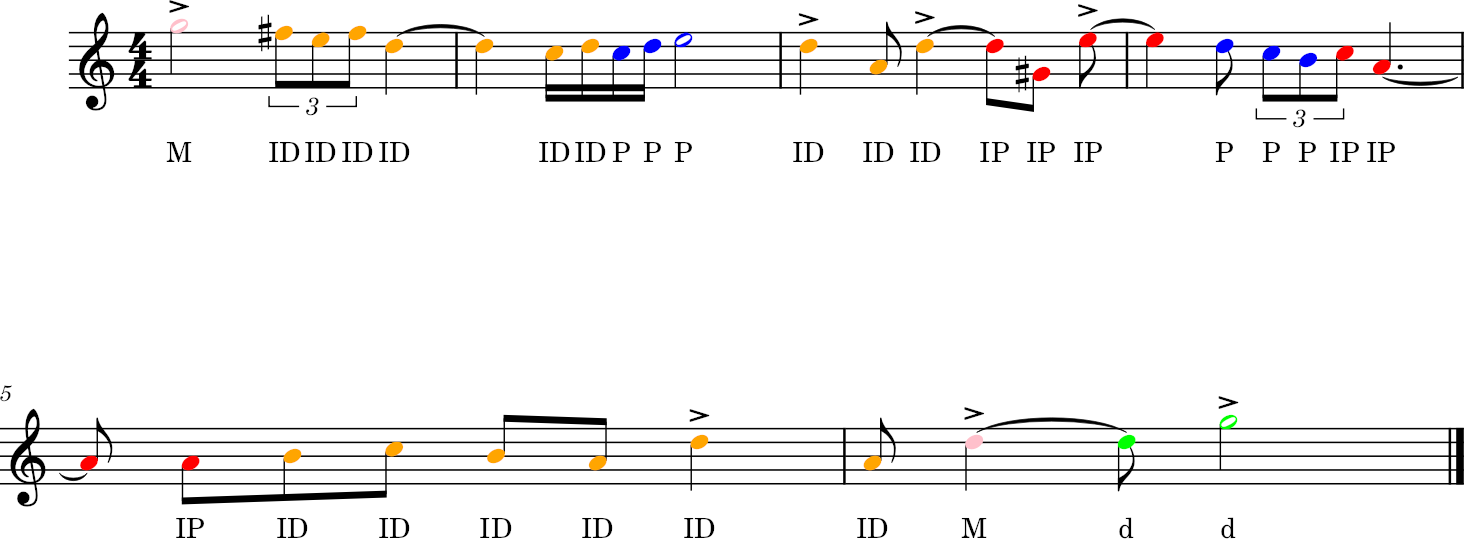

In [15]:
visualize_notes_with_symbols(test_ir)

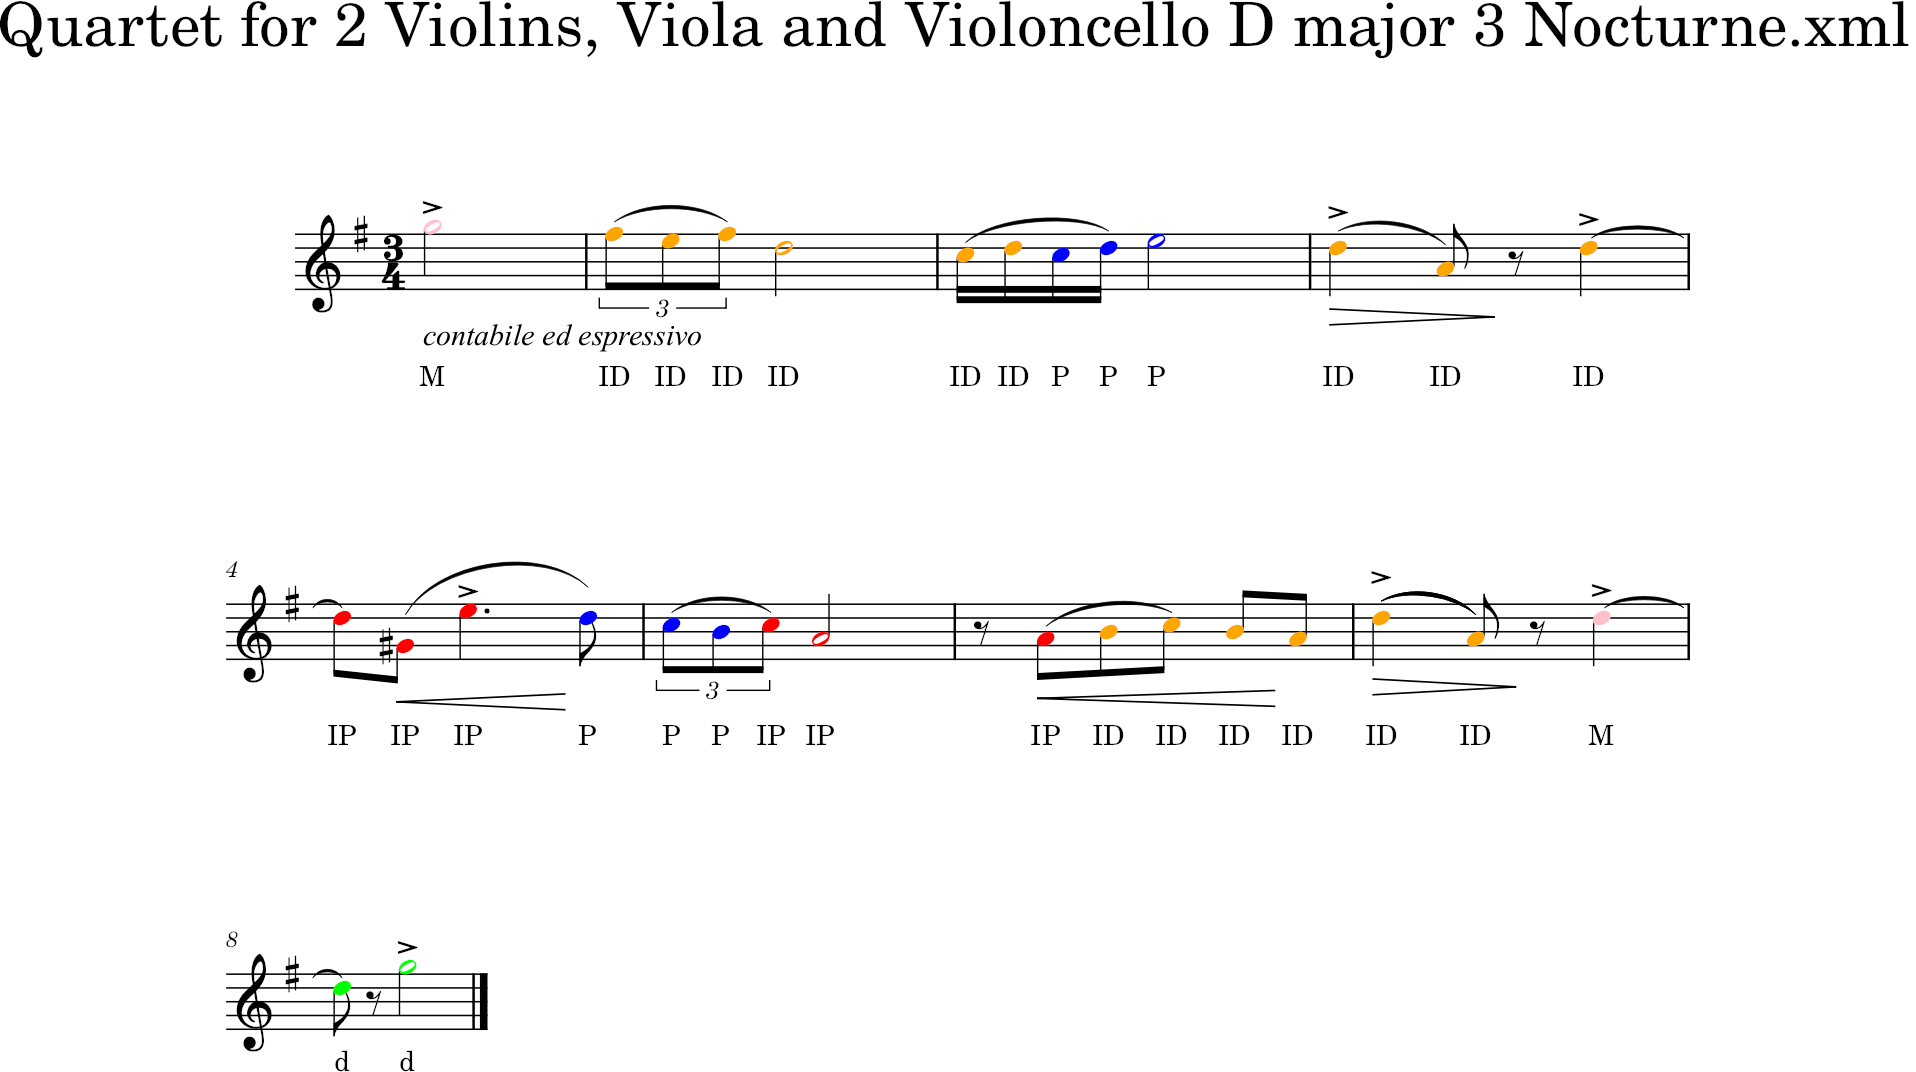

In [16]:
testscore.show()

In [17]:
def matrix_calculation(symbols):
    mat_calc = np.zeros((10, 10))
    # Count transitions
    for (current, upcoming) in zip(symbols[:-1], symbols[1:]):
        mat_calc[state_index[current[1]]][state_index[upcoming[1]]] += 1
    
    # Normalize the transition matrix to get probabilities
    sums = mat_calc.sum(axis=1)
    mat_calc = np.divide(mat_calc, sums[:, None], out=np.zeros_like(mat_calc), where=(sums[:, None] != 0))
    
    return mat_calc

In [18]:
composer_matrices = dict.fromkeys(directories, None)                # Composer matrix that is the average of piece matrices
composer_piece_matrices = dict.fromkeys(directories, None)          # Value of each composer is a list of all the piece matrices
aggregated_piece_matrices = dict.fromkeys(directories, None)        # Composer matrices made from the aggregate of all scores

for composer in composer_matrices:
    filepath = "../Music Database/GTTM Database/" + composer
    
    # Initializing the transition_matrix for a specific composer
    composer_matrix = np.zeros((10, 10))
    composer_pieces = []
    aggregated_symbols = []
    
    piece_count = 0
    for piece in os.listdir(filepath):
        score_path = os.path.join(filepath, piece)  # Get the path of particular piece
        score = converter.parse(score_path)         # Convert the piece into a music21 object
        notes = get_notes(score)                    # Extract elements for computation
        ir_symbols = assign_ir_symbols(notes)       # Assign IR symbols based on grouping
        aggregated_symbols.append(ir_symbols)       # A list for aggregated symbols
        
        # Create the matrix
        piece_matrix = matrix_calculation(ir_symbols)
        
        # Append to piece collection
        composer_pieces.append(piece_matrix)
        
        # Add the piece matrix to the composer matrix
        composer_matrix += piece_matrix
        piece_count += 1
        
    # Save the list of individual pieces in the dict
    composer_piece_matrices[composer] = composer_pieces
    
    # Markov chain for aggregated piece
    aggregated_symbols = [item for sublist in aggregated_symbols for item in sublist]
    piece_matrix = matrix_calculation(aggregated_symbols)
    aggregated_piece_matrices[composer] = piece_matrix
    
    # Average out all the piece matrices
    composer_matrix = composer_matrix/piece_count
    # Normalize the matrices
    for row in composer_matrix:
        row_sum = np.sum(row)
        if 0< row_sum <1:
            for i in range(len(row)):
                row[i] /= row_sum
                
    composer_matrices[composer] = composer_matrix

In [19]:
# Check for probabilities != 1
for composer in directories:
    for row in aggregated_piece_matrices[composer]:
        if np.sum(row) != 1 and np.sum(row) != 0:
            print(np.sum(row))

0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999


In [20]:
# Check for probabilities != 1
for composer in directories:
    for row in composer_matrices[composer]:
        if np.sum(row) != 1 and np.sum(row) != 0:
            print(np.sum(row))

0.9999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002


In [21]:
def transition_adjacency_matrix(matrix, states=None):
    if states is None:
        states = ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']
    transition_dict = {}
    for i, state in enumerate(states):
        row_dict = {}
        for j, prob in enumerate(matrix[i]):
            # if prob > 0:  # Only include non-zero probabilities
            row_dict[states[j]] = np.round(prob, decimals=3)
        transition_dict[state] = row_dict
    return transition_dict

In [22]:
def create_graphs(transition_matrices):
    n = len(transition_matrices)
    
    # Define node positions (adjust dictionary for your layout)
    node_positions = {
        'VP': (0, 1.5),
        'P': (-1, 1),
        'D': (1, 1),
        'VR': (-1.5, 0),
        'IP': (1.5, 0),
        'ID': (-1, -1),
        'IR': (1, -1),
        'R': (0, -1.5),
        'M': (0, 0),
        'd': (0.5, -0.5),
    }

    # Define node colors (adjust color names for preference)
    node_colors = {
        'VP': '#dce317',
        'P': '#94d840',
        'D': '#56c667',
        'VR': '#29af7f',
        'IP': '#1f968b',
        'ID': '#277d8e',
        'IR': '#32648e',
        'R': '#453781',
        'M': '#fde725',
        'd': '#440d54',
    }
    
    # Calculate the number of rows needed for two columns
    rows_needed = (n + 1) // 2  # Rounds up if odd number of graphs
    fig, axes = plt.subplots(rows_needed, 2, figsize=(12, rows_needed * 5))  # 2 columns, rows as needed
    
    if n == 1:
        axes = np.array([[axes]])  # Ensure axes is 2D array for single graph
    elif n == 2:
        axes = axes.reshape(-1, 2)  # Reshape to ensure 2 columns when exactly two graphs
    
    # Flatten the axes array and iterate over each subplot axis
    axes = axes.flatten()
    for ax, (title, matrix) in zip(axes[:n], transition_matrices.items()):
        transition_dict = transition_adjacency_matrix(matrix)
        G = nx.DiGraph()
        for source, transitions in transition_dict.items():
            for dest, prob in transitions.items():
                if prob > 0:
                    G.add_edge(source, dest, weight=prob)
        
        # Use node_positions for fixed positions
        pos = node_positions

        # Use node_colors dictionary for node coloring
        node_colors_list = [node_colors[node] for node in G.nodes]

        edge_labels = nx.get_edge_attributes(G, 'weight')
        
        nx.draw(G, pos, with_labels=True, node_color=node_colors_list, node_size=2000, edge_color='#3b0a45', width=2, arrowstyle='-|>', arrowsize=10, ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, ax=ax)
        
        ax.set_title(title)
        ax.axis('off')
    
    # Hide any unused axes if there are fewer graphs than subplots
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig("markovchains.png", dpi=800)
    plt.show()

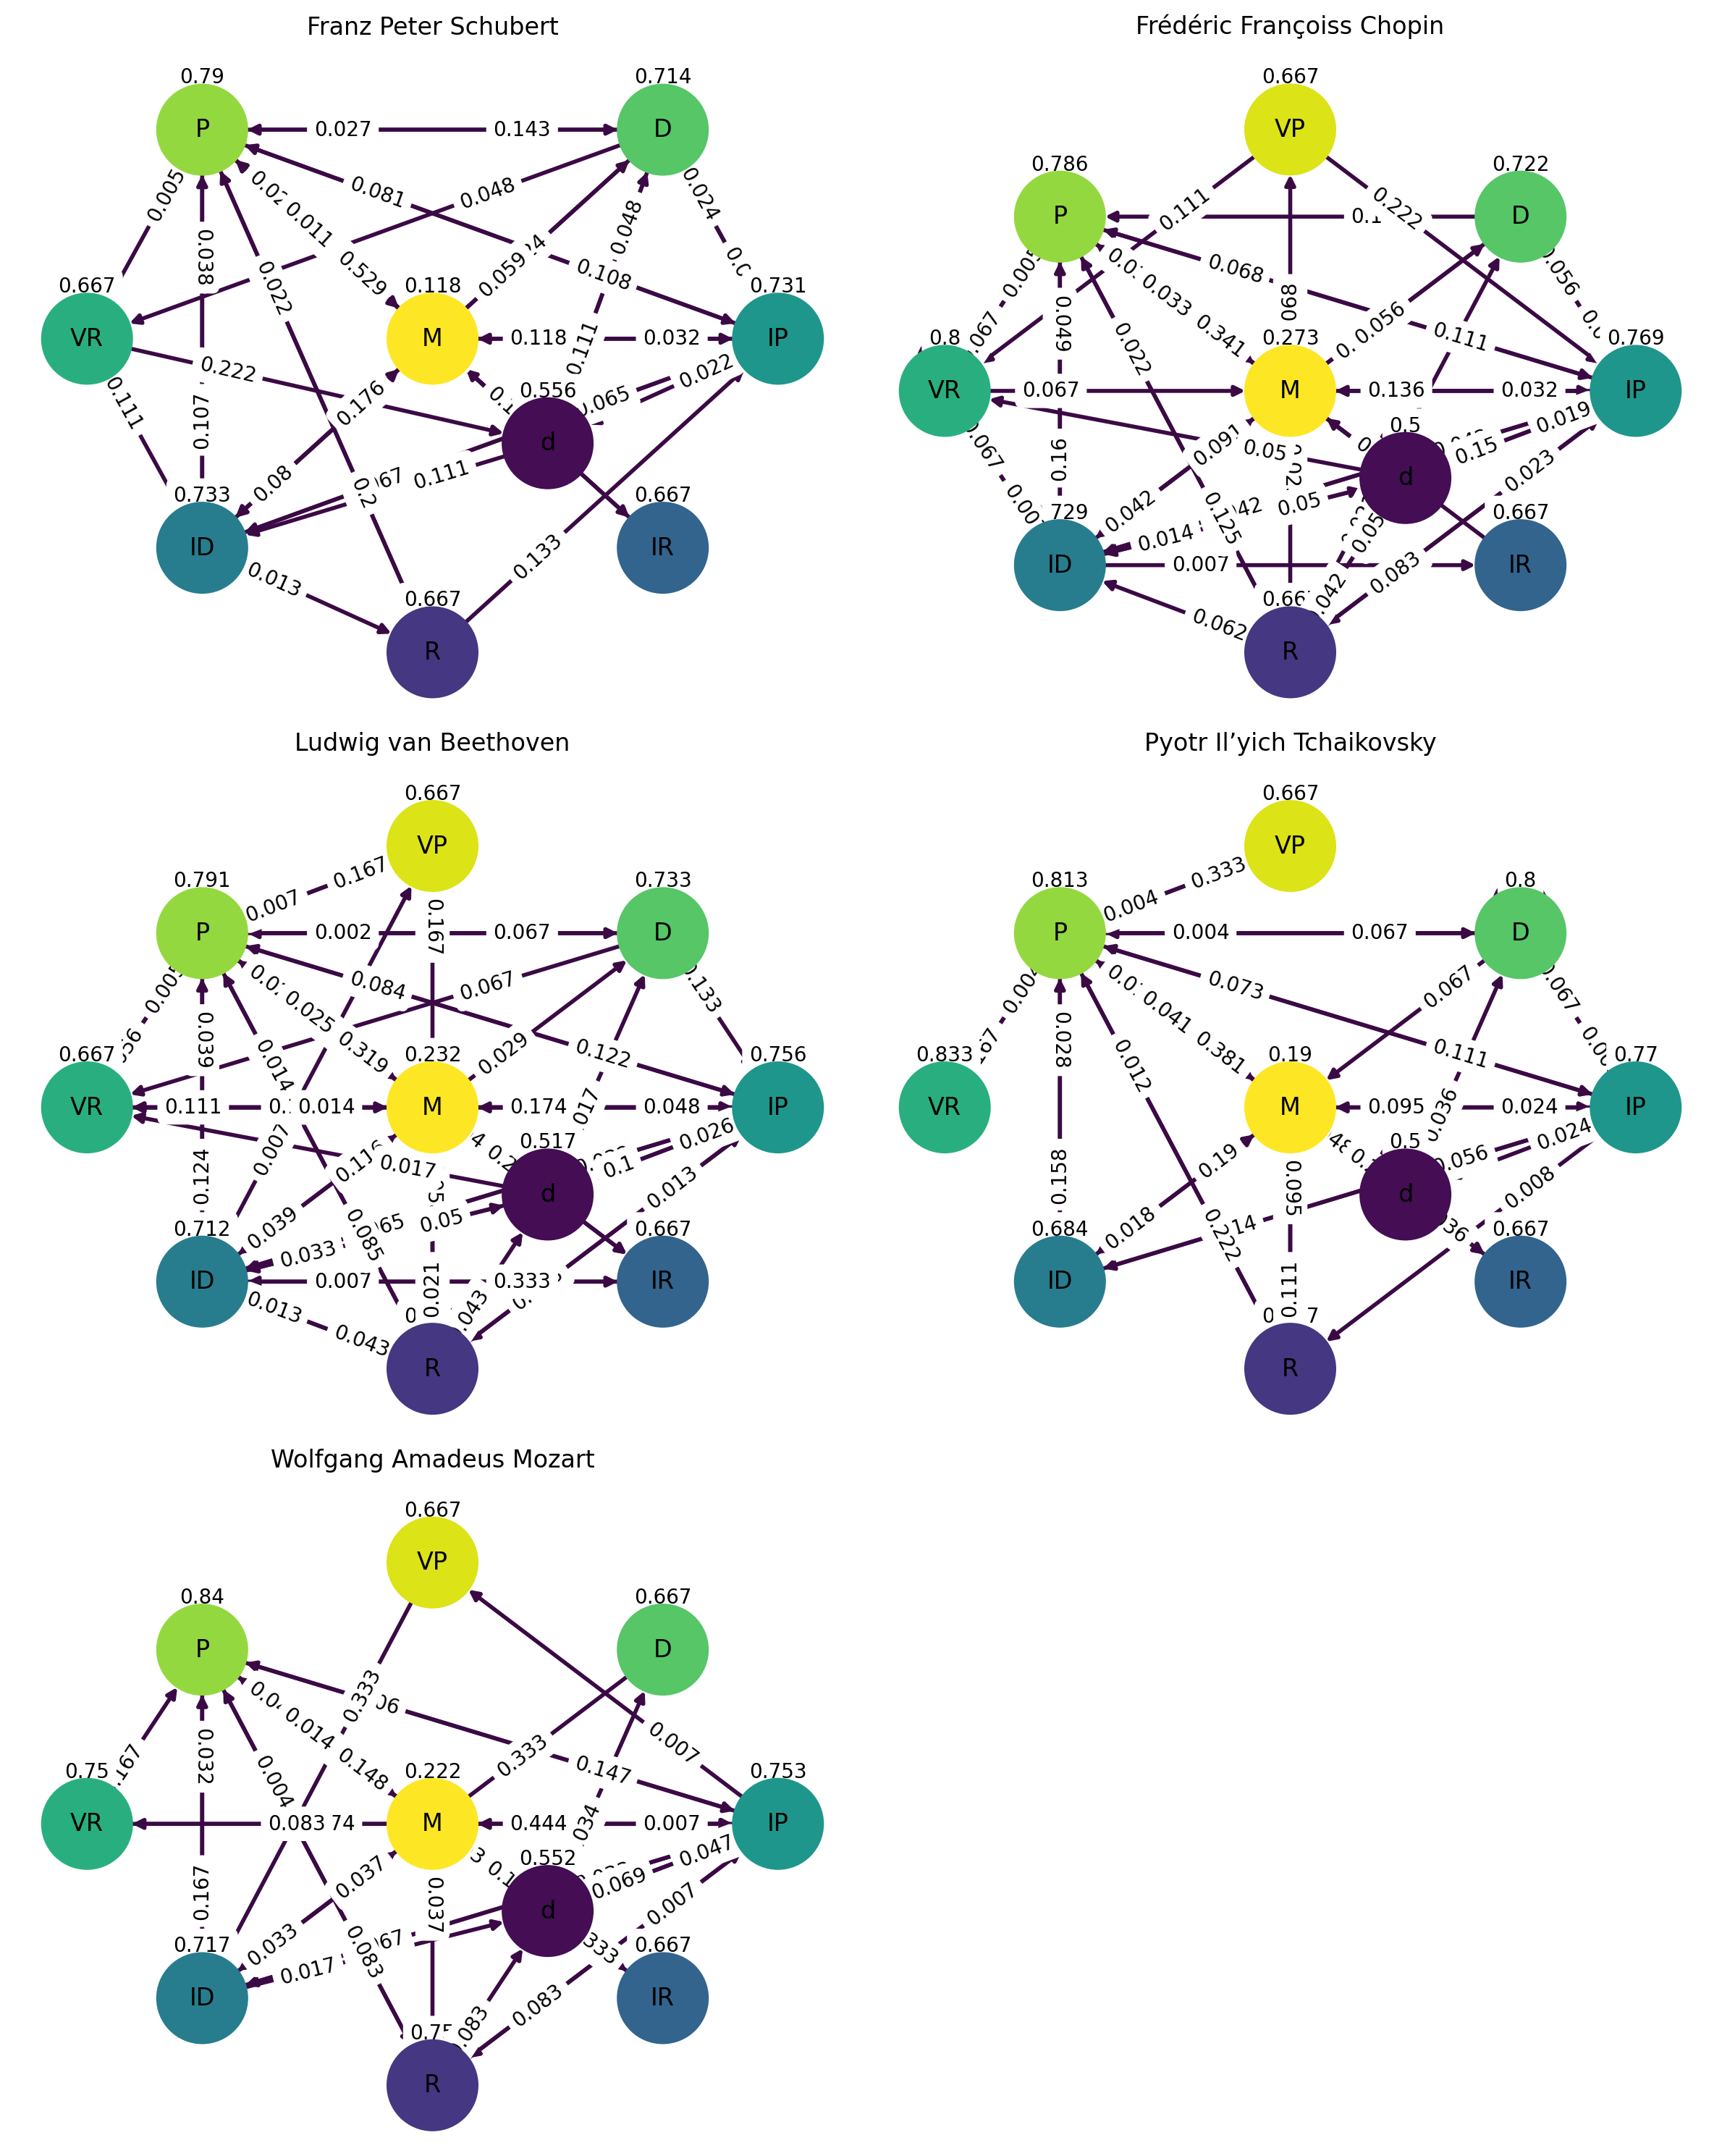

In [23]:
create_graphs(aggregated_piece_matrices)

# IR Analysis

In [24]:
class MarkovChain:
    def __init__(self, transition_matrix, initial_state, state_labels=None):
        # Ensure transition matrix is np array and column stochastic
        transition_matrix = np.array(transition_matrix)
        if not np.allclose(transition_matrix.sum(axis=0), 1):
            transition_matrix = transition_matrix.T
            # raise ValueError("The transition matrix is not column stochastic.")

        self.transition_matrix = transition_matrix

        # Initialize
        initial_state = np.array(initial_state).reshape(-1, 1)
        self.initial_state = initial_state
        self.current_state = initial_state

        # State labels
        if state_labels is None:
            state_labels = list(range(transition_matrix.shape[0]))
        self.state_labels = state_labels
        self.states_history = [initial_state.flatten().tolist()]

    def iterate(self, steps=1):
        for i in range(steps):
            self.current_state = np.dot(self.transition_matrix, self.current_state)
            self.states_history.append(self.current_state.flatten().tolist())
        return self.current_state

    def get_states_history(self):
        return pd.DataFrame(self.states_history, columns=self.state_labels)
    
    def plot_states(self, ax=None, title=None):
        df = self.get_states_history()
        if ax is None:
            ax = plt.gca()
        df.plot(ax=ax)
        if title is not None:
            ax.set_title(title)
        else:
            ax.set_title("State Probabilities Over Time")
        ax.set_xlabel("Step")
        ax.set_ylabel("Probability")
        ax.legend(self.state_labels)
        
    def pie_plot(self, ax=None, title=None, colors=None):
        df = self.get_states_history()
        last_row = df.iloc[-1]
        
        if ax is None:
            ax = plt.gca()

        # Define colors for the pie chart based on state labels
        pie_colors = [colors[label] if label in colors else '#333333' for label in self.state_labels]

        ax.pie(last_row, labels=self.state_labels, autopct='%1.1f%%', colors=pie_colors)
        
        if title is not None:
            ax.set_title(title)
        else:
            ax.set_title("Final State Distribution")

### State probability graphs

In [25]:
initial_state = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0, 0] # Equal chance for all except for M and d

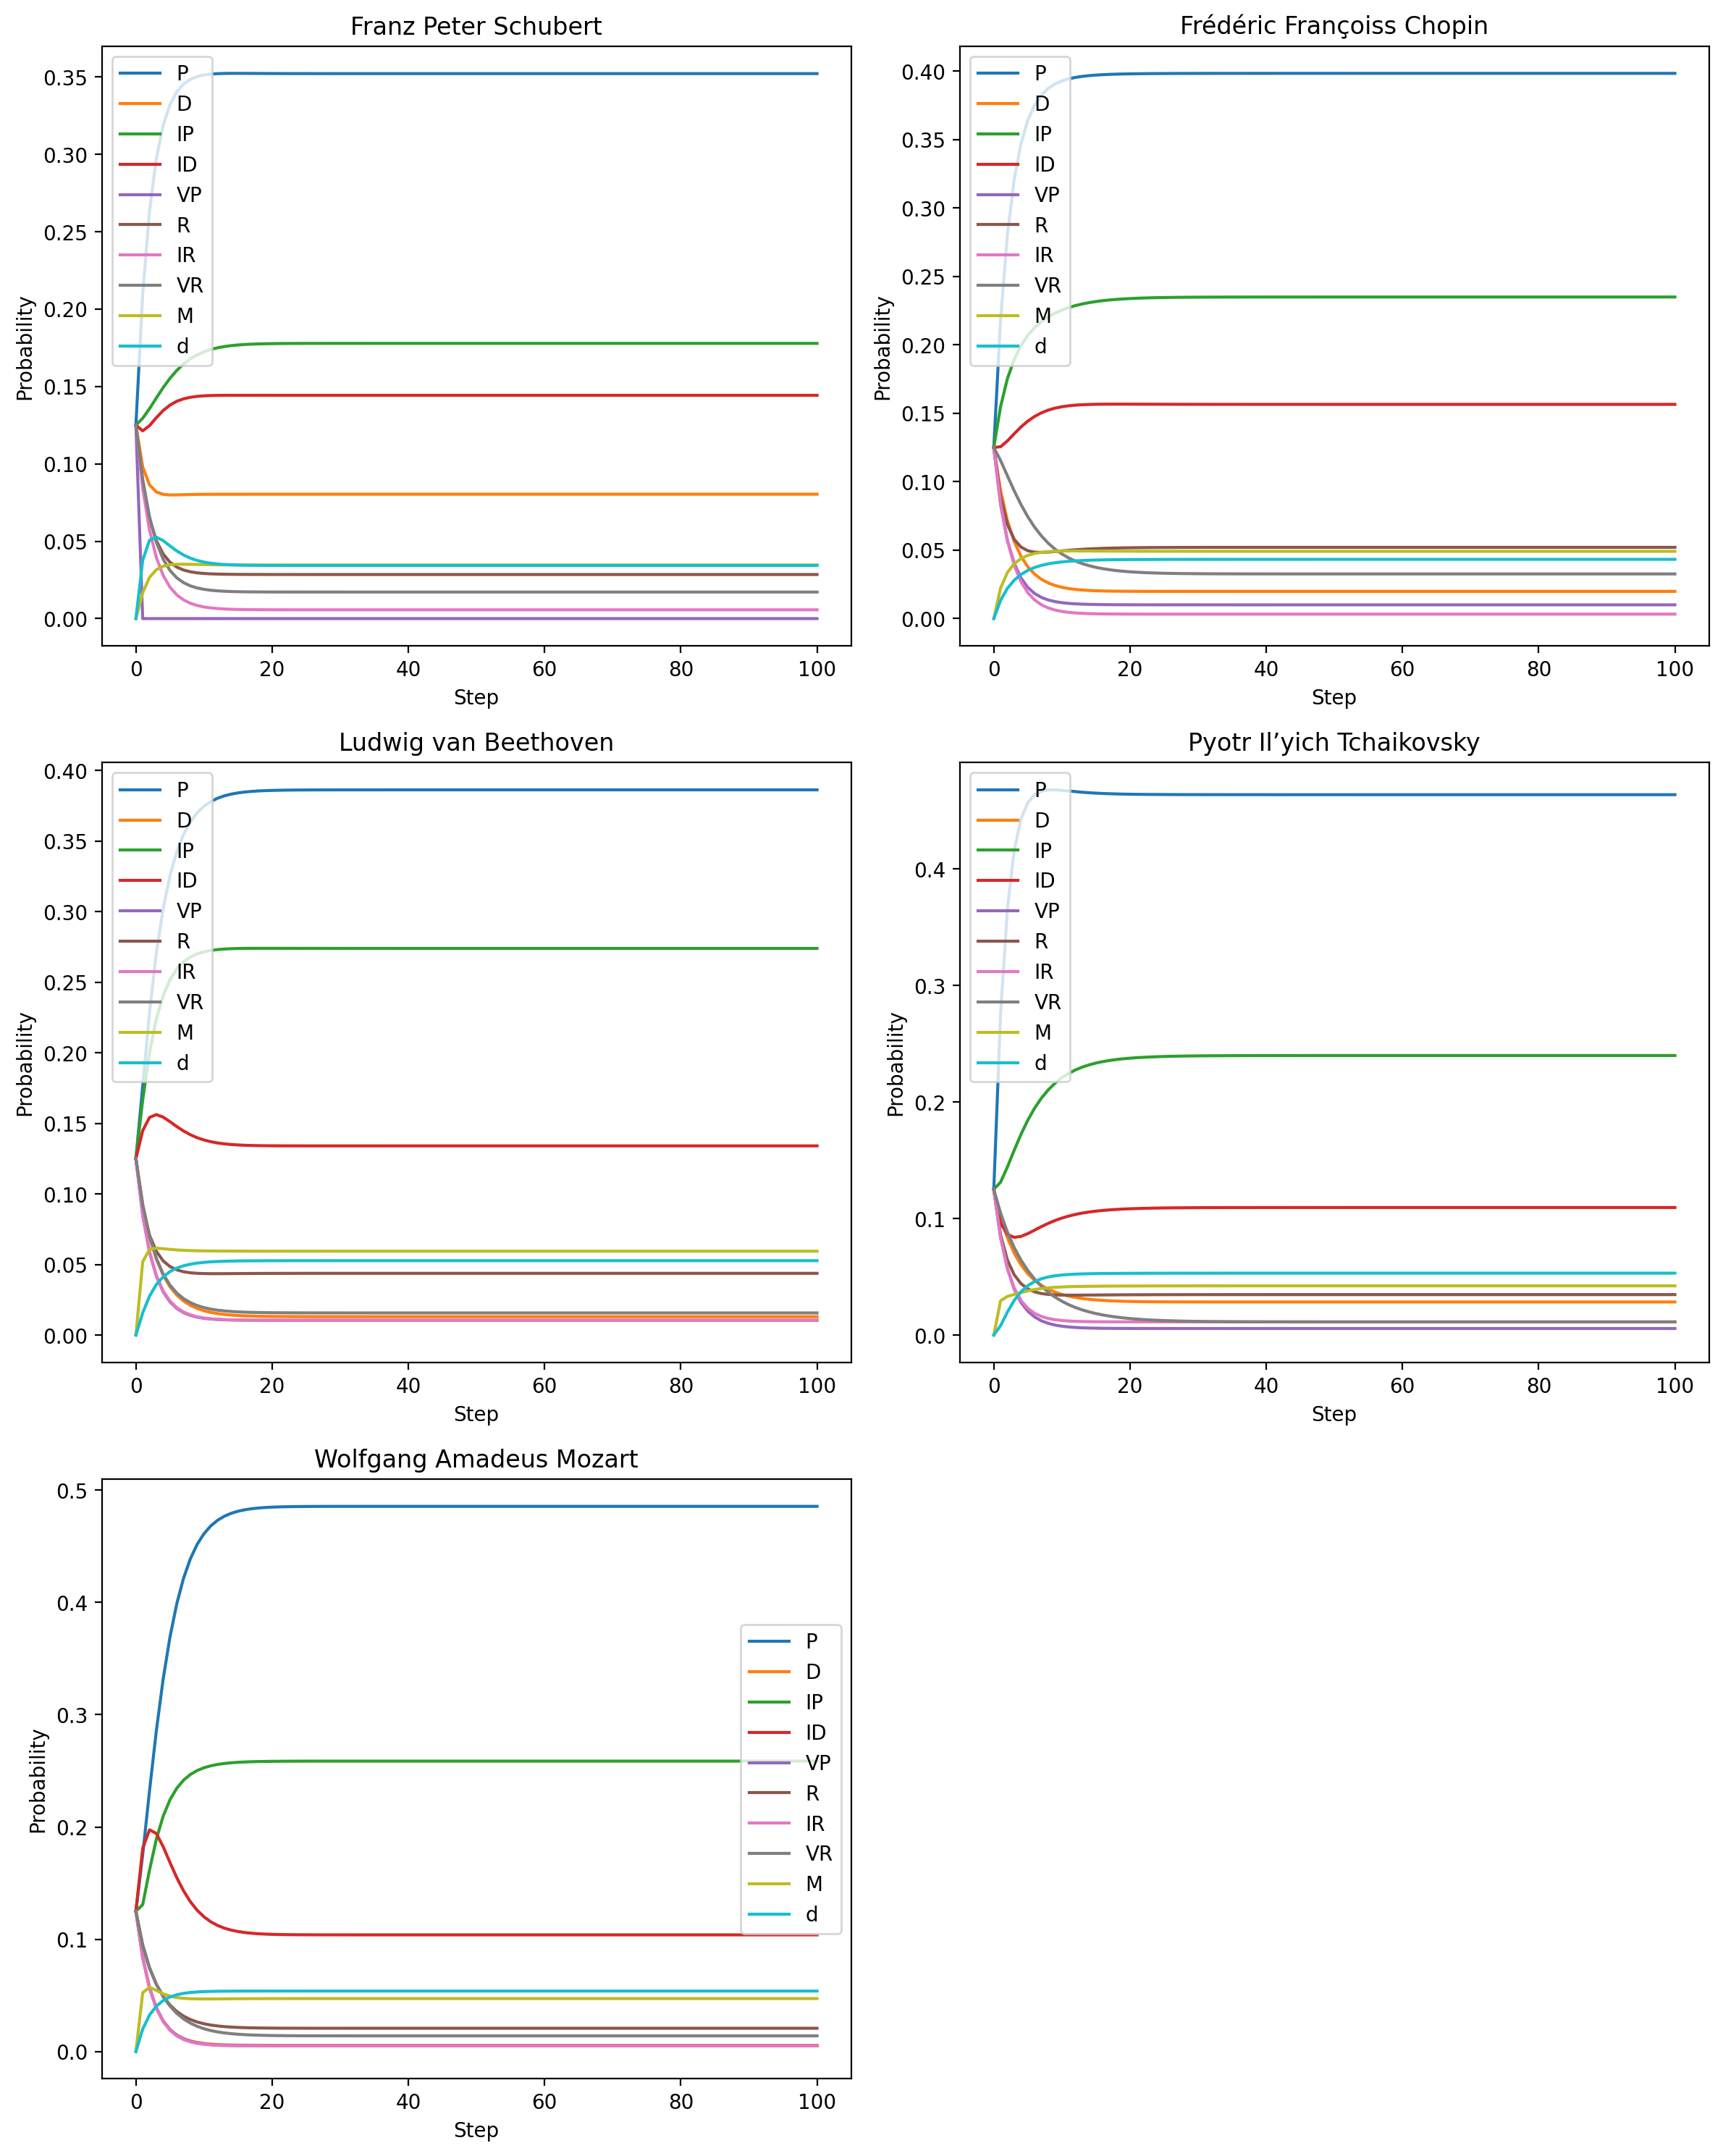

In [26]:
# Number of composers (assuming 'directories' is a list of identifiers or actual directory paths)
num_composers = len(directories)
rows_needed = (num_composers + 1) // 2  # Calculates the rows needed for two columns

# Create a subplot grid
fig, axes = plt.subplots(rows_needed, 2, figsize=(12, rows_needed * 5))
axes = axes.flatten()  # Flatten to make indexing easier

for idx, composer in enumerate(directories):
    # Assuming aggregated_piece_matrices and initial_state are predefined and appropriate for each composer
    mChain = MarkovChain(aggregated_piece_matrices[composer], initial_state, states)
    mChain.iterate(100)
    
    # Plot using the provided axis and set the title to the composer's name
    mChain.plot_states(ax=axes[idx], title=composer)

# Hide any unused axes if there are fewer chains than subplot slots
for ax in axes[num_composers:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig("spg.png", dpi=800)
plt.show()


### Pie charts

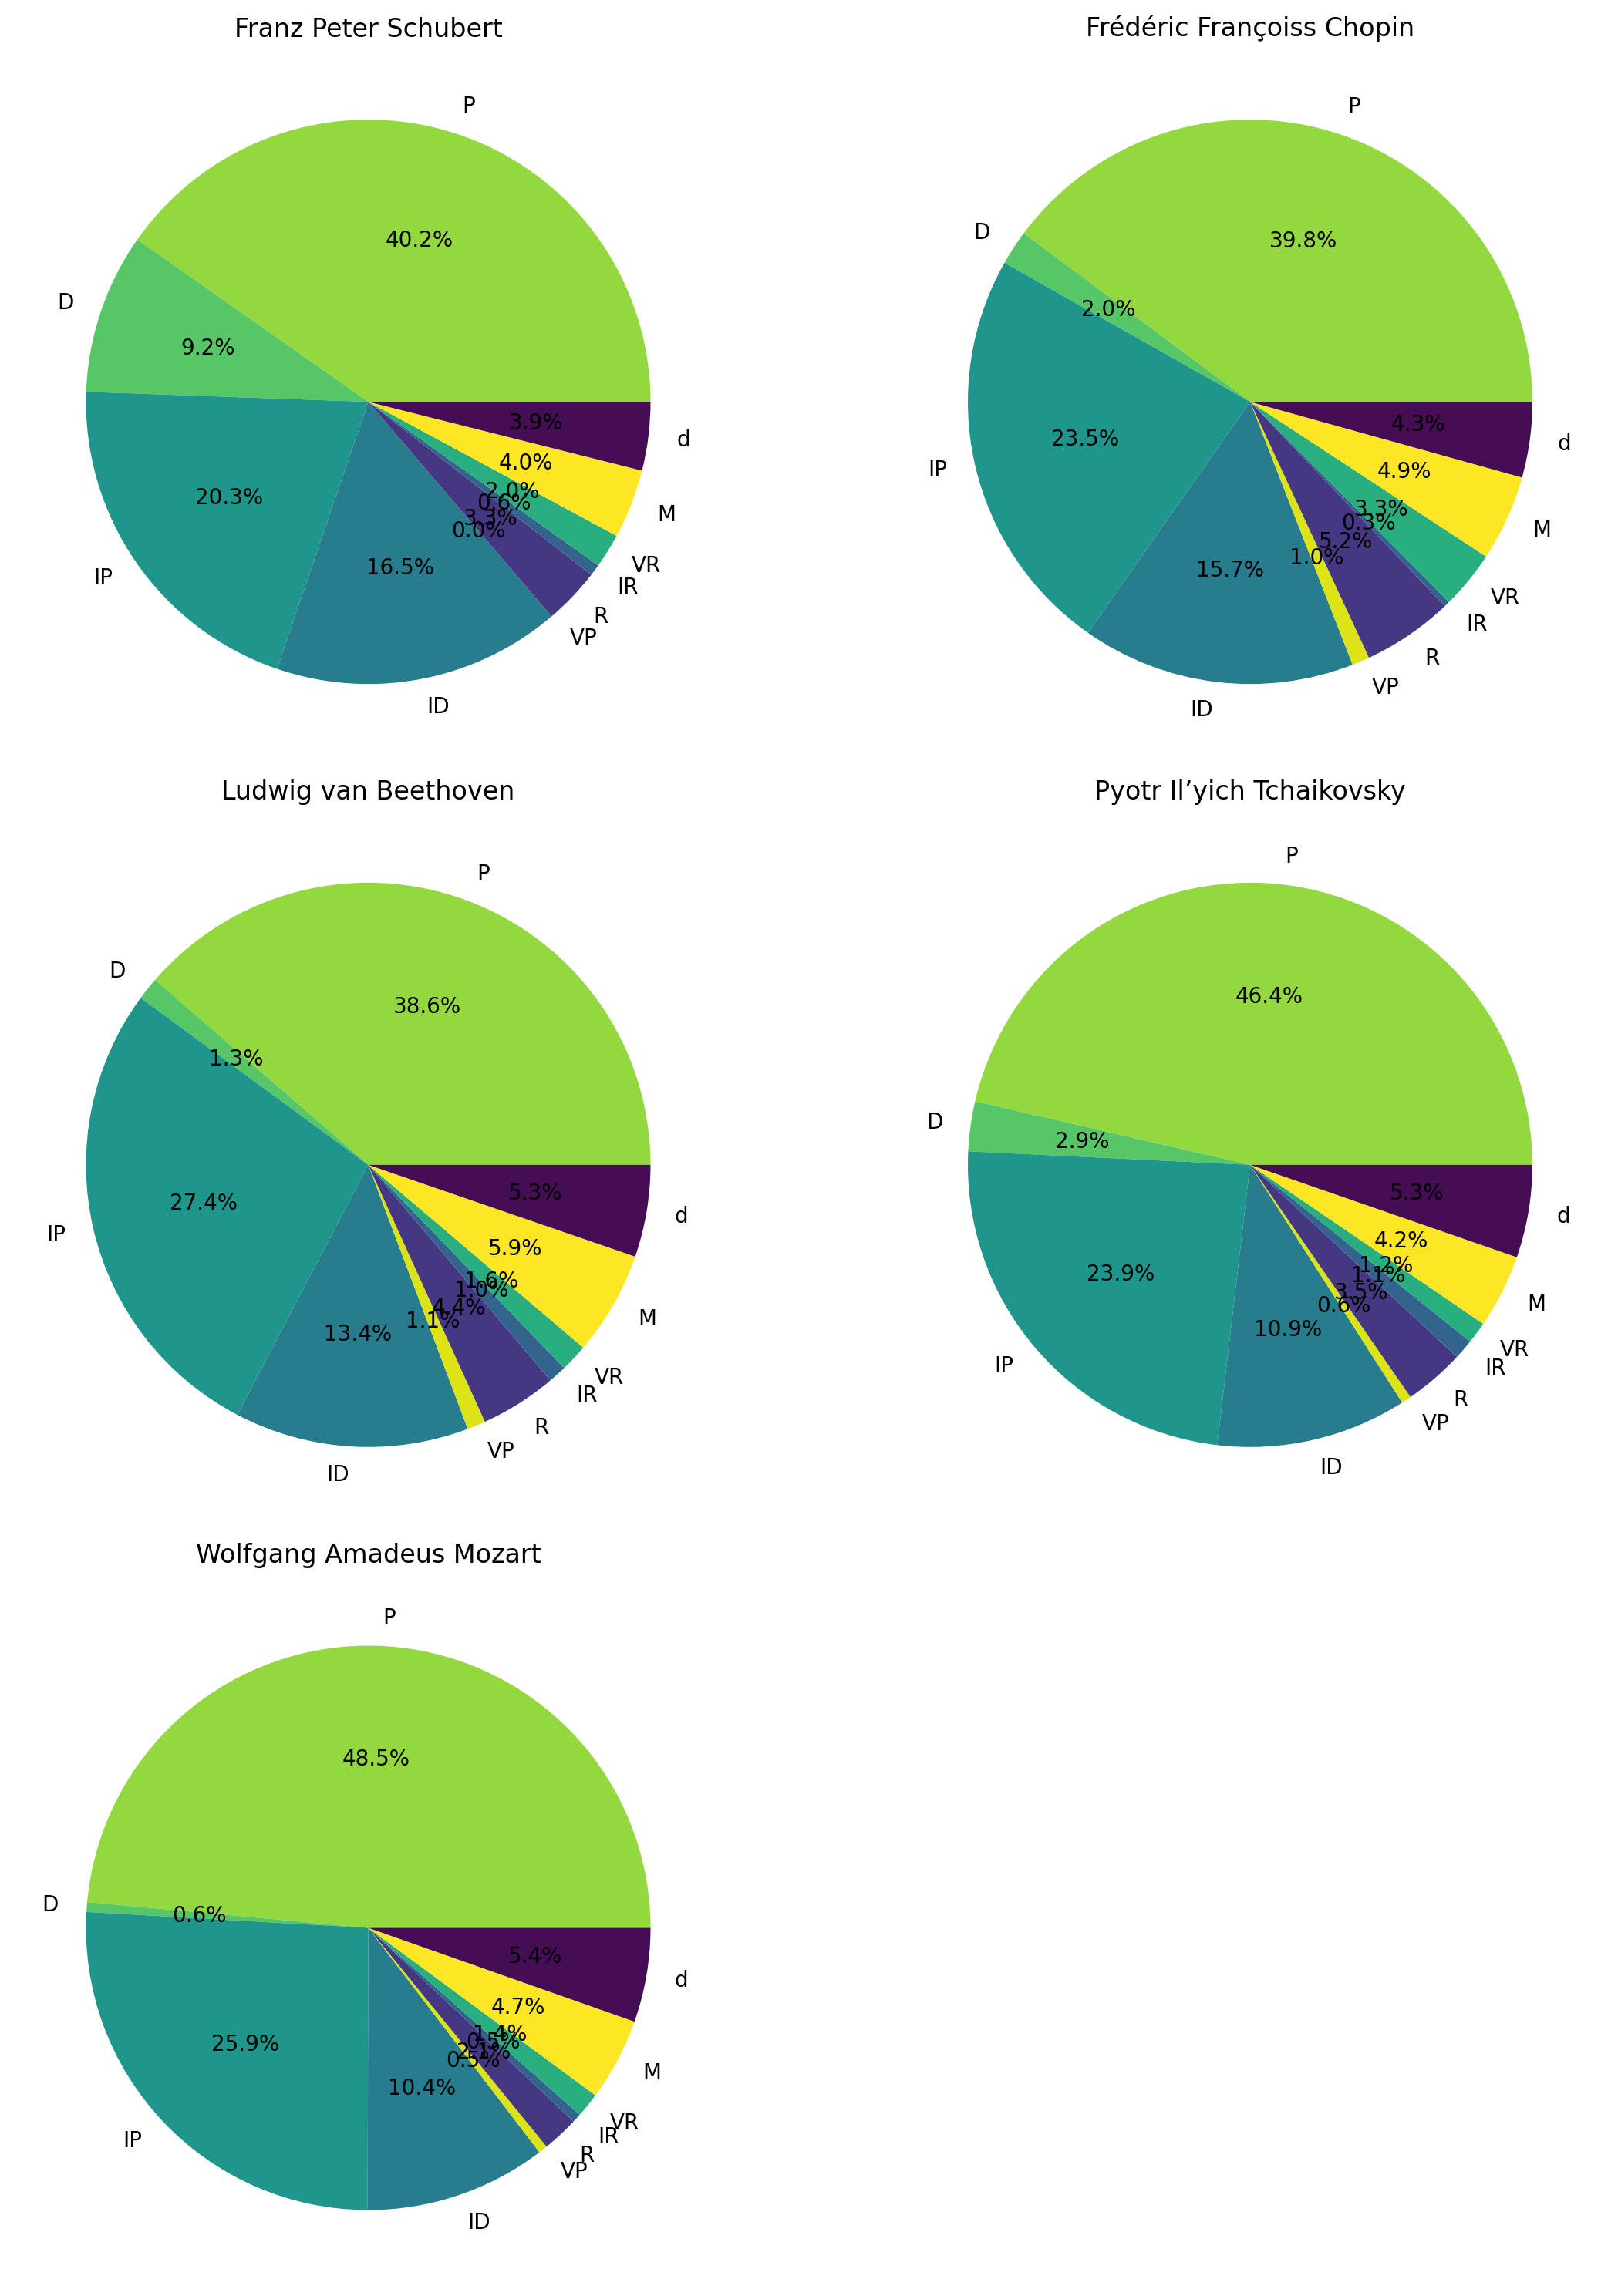

In [27]:
# Define node colors
node_colors = {
    'VP': '#dce317',
    'P': '#94d840',
    'D': '#56c667',
    'VR': '#29af7f',
    'IP': '#1f968b',
    'ID': '#277d8e',
    'IR': '#32648e',
    'R': '#453781',
    'M': '#fde725',
    'd': '#440d54',
}

# Number of composers
num_composers = len(directories)
rows_needed = (num_composers + 1) // 2

# Create subplot grid
fig, axes = plt.subplots(rows_needed, 2, figsize=(12, rows_needed * 5))
axes = axes.flatten()

for idx, composer in enumerate(directories):
    mChain = MarkovChain(aggregated_piece_matrices[composer], initial_state, states)
    mChain.iterate(25)
    
    # Pass the custom colors to plot_states
    mChain.pie_plot(ax=axes[idx], title=composer, colors=node_colors)

# Hide any unused axes
for ax in axes[num_composers:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig("pie.png", dpi=800)
plt.show()


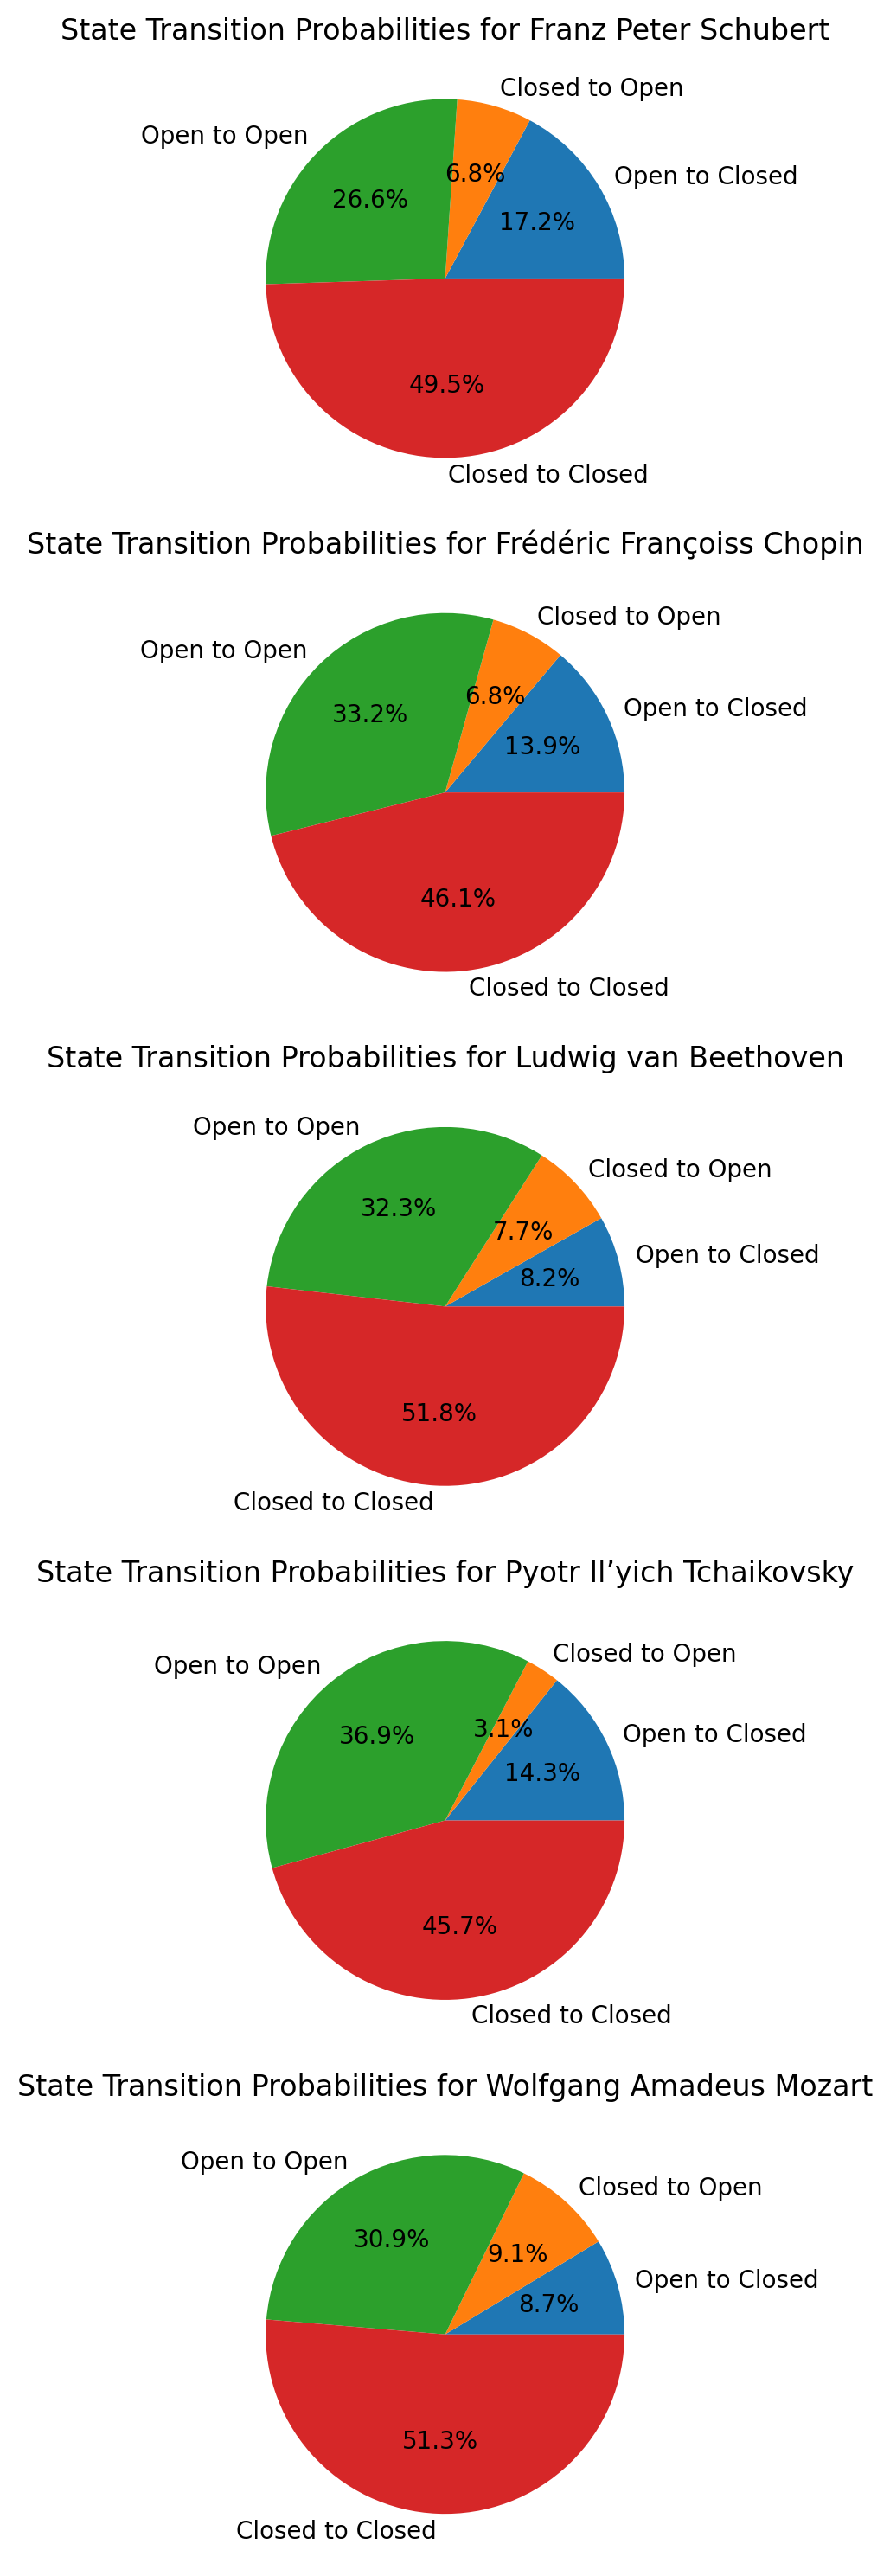

In [28]:
states = ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']
closure_degrees = {'P': 0.775, 'D': 0.7, 'IP': 0.325, 'ID': 0.4375, 'VP': 0.9, 'R': 0.1, 'IR': 0.2125, 'VR': 0.55, 'M': 0, 'd': 0}

# Plotting results for each composer
fig, axes = plt.subplots(len(directories), figsize=(10, 3 * len(directories)))

if len(directories) == 1:
    axes = [axes]  # Ensure axes is iterable if only one composer

for ax, composer in zip(axes, directories):
    matrix = transition_adjacency_matrix(aggregated_piece_matrices[composer])
    df_transition = pd.DataFrame(matrix, index=states, columns=states)

    open_states = [state for state, degree in closure_degrees.items() if degree > 0.5]
    closed_states = [state for state, degree in closure_degrees.items() if degree <= 0.5]

    # Calculate probabilities
    prob_open_to_closed = df_transition.loc[open_states, closed_states].sum().sum()
    prob_closed_to_open = df_transition.loc[closed_states, open_states].sum().sum()
    prob_open_to_open = df_transition.loc[open_states, open_states].sum().sum()
    prob_closed_to_closed = df_transition.loc[closed_states, closed_states].sum().sum()

    # Normalize probabilities (if needed)
    total = prob_open_to_closed + prob_closed_to_open + prob_open_to_open + prob_closed_to_closed
    probabilities = [prob_open_to_closed, prob_closed_to_open, prob_open_to_open, prob_closed_to_closed] / total

    # Labels for the pie chart
    labels = ['Open to Closed', 'Closed to Open', 'Open to Open', 'Closed to Closed']

    # Plot
    ax.pie(probabilities, labels=labels, autopct='%1.1f%%')
    ax.set_title(f"State Transition Probabilities for {composer}")

plt.tight_layout()
plt.savefig("ctoo.png", dpi=800)
plt.show()

# Validation Methods

In [29]:
# Baroque Era Composers
baroque_composers = [
    "Johann Sebastian Bach",
    "Georg Friedrich Händel",
    "Jean-Philippe Rameau"
]

# Classical Era Composers
classical_composers = [
    "Franz Joseph Haydn",
    "Wolfgang Amadeus Mozart",
    "Ludwig van Beethoven",  
    "Muzio Filippo Vincenzo Francesco Saverio Clementi"
]

# Romantic Era Composers
romantic_composers = [
    "Ludwig van Beethoven",  # Transitional figure
    "Franz Peter Schubert",
    "Jakob Ludwig Felix Mendelssohn Bartholdy",
    "Frédéric Françoiss Chopin",
    "Robert Alexander Schumann",
    "Johannes Brahms",
    "Giuseppe Fortunino Francesco Verdi",
    "Wilhelm Richard Wagner",
    "Pyotr Il’yich Tchaikovsky",
    "Georges Bizet",
    "Giacomo Antonio Domenico Michele Secondo Maria Puccini" 
]

### KL Divergence

In [30]:
def kl_divergence(p, q):
    epsilon = 1e-10  # small epsilon value to avoid division by zero
    p_safe = p + epsilon
    q_safe = q + epsilon
    return np.sum(p_safe * np.log(p_safe / q_safe))

def average_kl_within_era(composer_piece_matrices, era_composers):
    """
    Compute the average KL divergence of all possible pairs within a specific era of composers.
    
    Parameters:
    composer_piece_matrices (dict): Dictionary mapping composer directories to lists of matrices.
    era_composers (list): List of composers belonging to a specific era.
    
    Returns:
    float: Average KL divergence within the era of composers.
    """
    total_kl = 0
    count = 0
    for composer in era_composers:
        matrices = composer_piece_matrices.get(composer, [])
        for i in range(len(matrices)):
            for j in range(i + 1, len(matrices)):
                total_kl += kl_divergence(matrices[i], matrices[j])
                count += 1
    return total_kl / count if count > 0 else 0

def average_kl_between_eras(composer_piece_matrices, era1_composers, era2_composers):
    """
    Compute the average KL divergence of all possible pairs between two eras of composers.
    
    Parameters:
    composer_piece_matrices (dict): Dictionary mapping composer directories to lists of matrices.
    era1_composers (list): List of composers belonging to the first era.
    era2_composers (list): List of composers belonging to the second era.
    
    Returns:
    float: Average KL divergence between the eras of composers.
    """
    total_kl = 0
    count = 0
    for composer1 in era1_composers:
        matrices1 = composer_piece_matrices.get(composer1, [])
        for composer2 in era2_composers:
            matrices2 = composer_piece_matrices.get(composer2, [])
            for matrix1 in matrices1:
                for matrix2 in matrices2:
                    total_kl += kl_divergence(matrix1, matrix2)
                    count += 1
    return total_kl / count if count > 0 else 0

In [31]:
# Compute average KL divergence within each era
era_avg_kl_within = {}
era_composers = {
    "Baroque Era": baroque_composers,
    "Classical Era": classical_composers,
    "Romantic Era": romantic_composers,
}

for era, composers in era_composers.items():
    era_avg_kl_within[era] = average_kl_within_era(composer_piece_matrices, composers)

# Compute average KL divergence between different eras
era_avg_kl_between = {}
eras = list(era_composers.keys())
for i in range(len(eras)):
    for j in range(i + 1, len(eras)):
        era1 = eras[i]
        era2 = eras[j]
        era_avg_kl_between[f"{era1} vs {era2}"] = average_kl_between_eras(composer_piece_matrices, era_composers[era1], era_composers[era2])

In [32]:
# Output the results
print("Average KL Divergence within each era:")
for era, avg_kl in era_avg_kl_within.items():
    print(f"{era}: {avg_kl}")

print("\nAverage KL Divergence between different eras:")
for era_pair, avg_kl in era_avg_kl_between.items():
    print(f"{era_pair}: {avg_kl}")


Average KL Divergence within each era:
Baroque Era: 0
Classical Era: 46.94629521123967
Romantic Era: 46.290742538644274

Average KL Divergence between different eras:
Baroque Era vs Classical Era: 0
Baroque Era vs Romantic Era: 0
Classical Era vs Romantic Era: 51.47194685290629


### Entropy Rate

In [33]:
composer_matrices['Louis A. Saint-Jacome']

KeyError: 'Louis A. Saint-Jacome'

In [ ]:
matrix = np.array(composer_matrices['Ludwig van Beethoven'])
matrix

In [ ]:

# Check if matrix is square
if matrix.shape[0] != matrix.shape[1]:
    raise ValueError("Matrix must be square to form a valid Markov chain.")

In [ ]:

# Calculate the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(matrix.T)
print(f"Eigenvalues: {eigenvalues} \n Eigenvectors: {eigenvectors}")

In [ ]:
stationary_distribution = np.real(eigenvectors[:, np.isclose(eigenvalues, 1)].flatten())
stationary_distribution

In [ ]:
if stationary_distribution.size == 0:
    raise ValueError("No stationary distribution found.")
stationary_distribution = stationary_distribution / stationary_distribution.sum()

# Calculate the entropy rate
entropy_rate = 0
for i in range(len(matrix)):
    entropy_rate -= stationary_distribution[i] * np.sum(
        matrix[i] * np.log2(matrix[i] + (matrix[i] == 0))
    )

In [34]:
def calculate_entropy_rate(transition_matrices):
    results = []
    for title, matrix in transition_matrices.items():
        try:
            matrix = np.array(matrix)

            # Check if matrix is square
            if matrix.shape[0] != matrix.shape[1]:
                raise ValueError("Matrix must be square to form a valid Markov chain.")

            # Calculate the stationary distribution
            eigenvalues, eigenvectors = np.linalg.eig(matrix.T)
            stationary_distribution = np.real(eigenvectors[:, np.isclose(eigenvalues, 1)].flatten())
            if stationary_distribution.size == 0:
                raise ValueError("No stationary distribution found.")
            stationary_distribution = stationary_distribution / stationary_distribution.sum()

            # Calculate the entropy rate
            entropy_rate = 0
            for i in range(len(matrix)):
                entropy_rate -= stationary_distribution[i] * np.sum(
                    matrix[i] * np.log2(matrix[i] + (matrix[i] == 0))
                )
            results.append({"Title": title, "Entropy Rate": entropy_rate})
        except Exception as e:
            results.append({"Title": title, "Entropy Rate": f"Error: {str(e)}"})
    return pd.DataFrame(results)

In [35]:
calculate_entropy_rate(composer_matrices)

,Title,Entropy Rate
0,Franz Peter Schubert,1.341759
1,Frédéric Françoiss Chopin,1.452031
2,Ludwig van Beethoven,1.431866
3,Pyotr Il’yich Tchaikovsky,1.215981
4,Wolfgang Amadeus Mozart,1.193948


### Chi-Squared Test

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
def test_homogeneity(transition_matrices, smoothing_value=1e-3):
    results = []
    for title, matrix in transition_matrices.items():
        try:
            print(f"Original matrix for {title}: \n{matrix}")
            
            # Apply Laplace smoothing to avoid zeros
            smoothed_matrix = matrix + smoothing_value
            # print(f"Smoothed matrix for {title}: \n{smoothed_matrix}")
            
            # Normalize rows to sum to 1 after smoothing
            row_sums = smoothed_matrix.sum(axis=1, keepdims=True)
            if np.any(row_sums == 0):
                # print(f"Error: Zero row sum after smoothing for {title}")
                continue
            smoothed_matrix /= row_sums
            # print(f"Normalized matrix for {title}: \n{smoothed_matrix}")
            
            # Flatten the matrix and append
            results.append(smoothed_matrix.flatten())
            print(f"Flattened matrix for {title}: \n{results[-1]}")
        except Exception as e:
            print(f"Error processing matrix {title}: {str(e)}")
            continue
    
    # Check the accumulated results before the chi-squared test
    # if results:
    #     print("Combined results before chi-squared test:")
    #     for idx, res in enumerate(results):
    #         print(f"Result {idx}: {res}")
    # else:
    #     return "No valid data to perform chi-squared test."

    # Perform chi-squared test on the smoothed data
    try:
        combined_data = np.vstack(results)
        print(f"Combined data for chi-squared test: \n{combined_data}")
        chi2, p_value, _, _ = chi2_contingency(combined_data.T)
        return chi2, p_value
    except ValueError as e:
        return f"Chi-squared test failed: {str(e)}"


In [ ]:
baroque_dict = {key: composer_matrices[key] for key in baroque_composers if key in composer_matrices}
test_homogeneity(baroque_dict)

In [ ]:
classical_dict = {key: composer_matrices[key] for key in classical_composers if key in composer_matrices}
test_homogeneity(classical_dict)

In [ ]:
romantic_dict = {key: composer_matrices[key] for key in romantic_composers if key in composer_matrices}
test_homogeneity(romantic_dict)

# K-Means Clustering

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
piece_matrices = []
for composer, matrix_list in composer_piece_matrices.items():
    for matrix in matrix_list:
        piece_matrices.append(matrix)

In [ ]:
flattened_piece_matrices = np.array([matrix.flatten() for matrix in piece_matrices])
flattened_piece_matrices

In [ ]:
# Number of clusters
k = 9

# Initialize the KMeans algorithm
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model
kmeans.fit(flattened_piece_matrices)

# Get the cluster labels for each matrix
cluster_labels = kmeans.labels_

# Print the cluster assignments
print("Cluster assignments for each Markov chain:")
for i, label in enumerate(cluster_labels):
    print(f"Markov Chain {i+1}: Cluster {label}")

# Calculate silhouette score to evaluate the clustering performance
silhouette_avg = silhouette_score(flattened_piece_matrices, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Optional: Analyze and interpret the cluster centers
print("Cluster Centers (averaged transition matrices):")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i}:")
    print(center.reshape((10, 10)))
